In [1]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def legend_without_duplicate_labels(ax, box = (1.1, 1.1)):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),**titlefont, bbox_to_anchor = box)

## Technical

In [4]:
name = "01_technical"
motion_name = "01_technical.csv"
midi_name = "01_technical_segm.csv"
correctness_name = "01_technical_segm_correctness.csv"

name = "02_technical"
motion_name = "02_technical.csv"
midi_name = "02_technical_segm.csv"
correctness_name = "02_technical_segm_correctness.csv"

# name = "02_Bach_BWV999_exp"
# motion_name = "02_Bach_BWV999_exp.csv"
# midi_name = "02_Bach_BWV999_exp_segm.csv"
# correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

# name = "02_Bach_BWV999_inexp"
# motion_name = "02_Bach_BWV999_inexp.csv"
# midi_name = "02_Bach_BWV999_inexp_segm.csv"
# correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")


In [5]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [6]:
LH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["LH parts"].values[0]
RH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["RH parts"].values[0]

In [7]:
def get_parts(parts):
    tmp = parts.split(".")
    parts = {}
    for l in tmp:
        l = l.split(" ")
        parts[l[0]] = [int(l[1]), int(l[2])]
        
    return parts

In [8]:
LH_parts = get_parts(LH_parts)
RH_parts = get_parts(RH_parts)

In [9]:
df_bpm_stats = pd.DataFrame(columns = [
    "Name",  "Part", "Hand", "Total BPM",
    "BPM asc", "BPM desc", "BPM desc-1", "BPM desc-2"] )

In [10]:

# This can be done with reasonable accuracy only if the meter is known, the meter doesn’t change, and the tempo remains the same throughout the song.
# Given these conditions, you could use the formula
# 𝑙(𝑟/𝑡)=𝑏, where
# 
# 𝑙 is the length of the song in minutes,
# 
# 𝑟 is the rate (beats per minute),
# 
# 𝑡 is the number of beats in a measure, and
# 
# 𝑏 is the number of measures.
# 

# technical one
b_dict = {
     'CMaj': 3.5,
     'Cmin': 3.5,
     'CMaj_arp': 2,
     'Cmin_arp': 2,
     'CMaj_oct': 3.5 
}

t_dict = {
     'CMaj': 4,
     'Cmin': 4,
     'CMaj_arp': 2,
     'Cmin_arp': 2,
     'CMaj_oct': 2     
}

# technical two
b_dict = {
     'CMaj': 3.5,
     'Cmin': 3.5,
     'CMaj_arp': 1.5,
     'Cmin_arp': 1.5,
     'CMaj_oct': 3.5,
     'Cmin_oct': 3.5,
}

t_dict = {
     'CMaj': 2,
     'Cmin': 2,
     'CMaj_arp': 2,
     'Cmin_arp': 2,
     'CMaj_oct': 4,
     'Cmin_oct': 4,
}

In [11]:
df_midi = df_midi[df_midi["Measure"]!=0]
for hand in ["LH", "RH"]:
    df_midi_hand = df_midi[df_midi["Hand"]==hand] 
    for key, value in eval(hand+"_parts").items():
        
        start = value[0]
        end = value[1]

        df_midi_hand_part = df_midi_hand[(start <= df_midi_hand["Start Midi"]) & (df_midi_hand["Start Midi"] <= end)]
        df_midi_hand_part.reset_index(inplace=True, drop=True)
        
        notes = df_midi_hand_part["Note"].values
        notes = [librosa.note_to_hz(n) for n in notes]
        highest_note = librosa.hz_to_note(max(notes))

        highest_note_index = df_midi_hand_part[df_midi_hand_part["Note"] == highest_note].index[0]
        
        start_frame_highest_note = df_midi_hand_part[df_midi_hand_part["Note"] == highest_note]["Start Midi"].values[0]
        end_frame_highest_note = df_midi_hand_part[df_midi_hand_part["Note"] == highest_note]["End Midi"].values[0]
    
        
        # total bpm
        duration = (df_midi_hand_part.iloc[-2]["End Midi"] - df_midi_hand_part.iloc[0]["Start Midi"])
        if "oct" in key:
            duration = (df_midi_hand_part.iloc[-3]["End Midi"] - df_midi_hand_part.iloc[0]["Start Midi"])
        duration_secs = duration/framerate
        
        b = 2*b_dict[key[3:]]
        t = t_dict[key[3:]]
        l = duration_secs
        total_bpm = b*t*60/l        
        
        # bpm ascending
        duration_asc = (df_midi_hand_part.loc[highest_note_index-1,"End Midi"] - df_midi_hand_part.iloc[0]["Start Midi"])
        duration_asc_secs = duration_asc/framerate
        
        b = b_dict[key[3:]]
        t = t_dict[key[3:]]
        l = duration_asc_secs
        bpm_asc = b*t*60/l

        # counting the last note, not used
        duration_desc = (df_midi_hand_part.iloc[-1]["End Midi"] - df_midi_hand_part.iloc[highest_note_index]["Start Midi"])
        l = duration_desc/framerate
        bpm_desc = b*t*60/l

        # counting the second from last note, used
        duration_desc = (df_midi_hand_part.iloc[-2]["End Midi"] - df_midi_hand_part.iloc[highest_note_index]["Start Midi"])
        l = duration_desc/framerate
        bpm_desc1 = b*t*60/l
        
        # counting the second from third note, used
        duration_desc = (df_midi_hand_part.iloc[-3]["End Midi"] - df_midi_hand_part.iloc[highest_note_index]["Start Midi"])
        l = duration_desc/framerate
        bpm_desc2 = b*t*60/l

        # save data about tempo
        df_bpm_stats = df_bpm_stats.append({
            "Name": motion_name,
            "Part": key,
            "Hand": hand,
            "Total BPM": total_bpm,
            "BPM asc": bpm_asc,
            "BPM desc": "",
            "BPM desc-1": bpm_desc1,
            "BPM desc-2": bpm_desc2
        }, ignore_index=True)
        df_bpm_stats.to_csv("./statistics/"+name+"_tempo_stats.csv")

    #     print(df_midi_hand_part_C.values)

In [12]:
df_bpm_stats

,Name,Part,Hand,Total BPM,BPM asc,BPM desc,BPM desc-1,BPM desc-2
0,02_technical.csv,LH_CMaj,LH,76.391415,73.375262,,78.828829,86.992543
1,02_technical.csv,LH_Cmin,LH,82.031250,80.831409,,83.333333,90.751945
2,02_technical.csv,LH_CMaj_arp,LH,78.328982,80.645161,,75.630252,99.118943
3,02_technical.csv,LH_Cmin_arp,LH,76.335878,80.213904,,72.815534,93.167702
4,02_technical.csv,LH_CMaj_oct,LH,141.652614,145.228216,,117.449664,143.835616
5,02_technical.csv,LH_Cmin_oct,LH,142.180095,131.250000,,120.620333,144.032922
6,02_technical.csv,RH_CMaj,RH,76.031861,73.119777,,78.475336,85.574572
7,02_technical.csv,RH_Cmin,RH,81.458495,79.605762,,82.417582,90.830450
8,02_technical.csv,RH_CMaj_arp,RH,80.357143,79.086116,,79.086116,96.566524
9,02_technical.csv,RH_Cmin_arp,RH,77.452668,77.720207,,75.376884,92.024540


## Bach

In [13]:
# name = "01_technical"
# motion_name = "01_technical.csv"
# midi_name = "01_technical_segm.csv"
# correctness_name = "01_technical_segm_correctness.csv"

# name = "02_technical"
# motion_name = "02_technical.csv"
# midi_name = "02_technical_segm.csv"
# correctness_name = "02_technical_segm_correctness.csv"

# name = "02_Bach_BWV999_exp"
# motion_name = "02_Bach_BWV999_exp.csv"
# midi_name = "02_Bach_BWV999_exp_segm.csv"
# correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

name = "02_Bach_BWV999_inexp"
motion_name = "02_Bach_BWV999_inexp.csv"
midi_name = "02_Bach_BWV999_inexp_segm.csv"
correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [14]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [15]:
bach_parts = {
    "Part 1 (m. 1-7)": (1,7), # first argument of tuple is measure, second is note
    "Part 2 (m. 7-12)": (7,13),
    "Part 3 (m. 13-16)": (13,16),
    "Part 4 (m. 16-20)": (16,20),
}

type_dict = {
    "02_Bach_BWV999_exp" : "Expressive",
    "02_Bach_BWV999_inexp" : "Inexpressive"
}

#### per measure

In [16]:
name = "02_Bach_BWV999_inexp"
motion_name = "02_Bach_BWV999_inexp.csv"
midi_name = "02_Bach_BWV999_inexp_segm.csv"
correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [17]:
df_bpm_bach_measure_inexp = pd.DataFrame(columns = [
    "Name",  "Measure", "Note count", "BPM"])

In [18]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [19]:
df_midi = df_midi[df_midi["Measure"]!=0]

for m in df_midi['Measure'].unique():
    
    if m!=43:
    
        df_midi_measure = df_midi[df_midi["Measure"]==m]
        df_midi_measure.reset_index(inplace=True, drop=True)

        count = df_midi_measure.shape[0]

        remainder = count/3 # 3 comes from 3/4 time signature

        duration = (df_midi_measure.loc[count-1,"End Midi"] - df_midi_measure.iloc[0]["Start Midi"])
        duration_secs = duration/framerate
        avg_duration = duration_secs/count

        bpm = 60/(remainder*avg_duration)

        # save data about tempo
        df_bpm_bach_measure_inexp = df_bpm_bach_measure_inexp.append({
            "Name": motion_name,
            "Measure": m,
            "Note count": count,
            "BPM": bpm
        }, ignore_index=True)
        df_bpm_bach_measure_inexp.to_csv("./statistics/"+name+"_tempo_stats.csv")


In [20]:
df_bpm_bach_measure_exp = pd.DataFrame(columns = [
    "Name",  "Measure", "Note count", "BPM"])

In [21]:
name = "02_Bach_BWV999_exp"
motion_name = "02_Bach_BWV999_exp.csv"
midi_name = "02_Bach_BWV999_exp_segm.csv"
correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [22]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [23]:
df_midi = df_midi[df_midi["Measure"]!=0]

for m in df_midi['Measure'].unique():
    
    if m!=43:
    
        df_midi_measure = df_midi[df_midi["Measure"]==m]
        df_midi_measure.reset_index(inplace=True, drop=True)

        count = df_midi_measure.shape[0]

        remainder = count/3 # 3 comes from 3/4 time signature

        duration = (df_midi_measure.loc[count-1,"End Midi"] - df_midi_measure.iloc[0]["Start Midi"])
        duration_secs = duration/framerate
        avg_duration = duration_secs/count

        bpm = 60/(remainder*avg_duration)

        # save data about tempo
        df_bpm_bach_measure_exp = df_bpm_bach_measure_exp.append({
            "Name": motion_name,
            "Measure": m,
            "Note count": count,
            "BPM": bpm
        }, ignore_index=True)
        df_bpm_bach_measure_exp.to_csv("./statistics/"+name+"_tempo_stats.csv")


#### per part

NameError: name 'df_bpm_bach_measure' is not defined

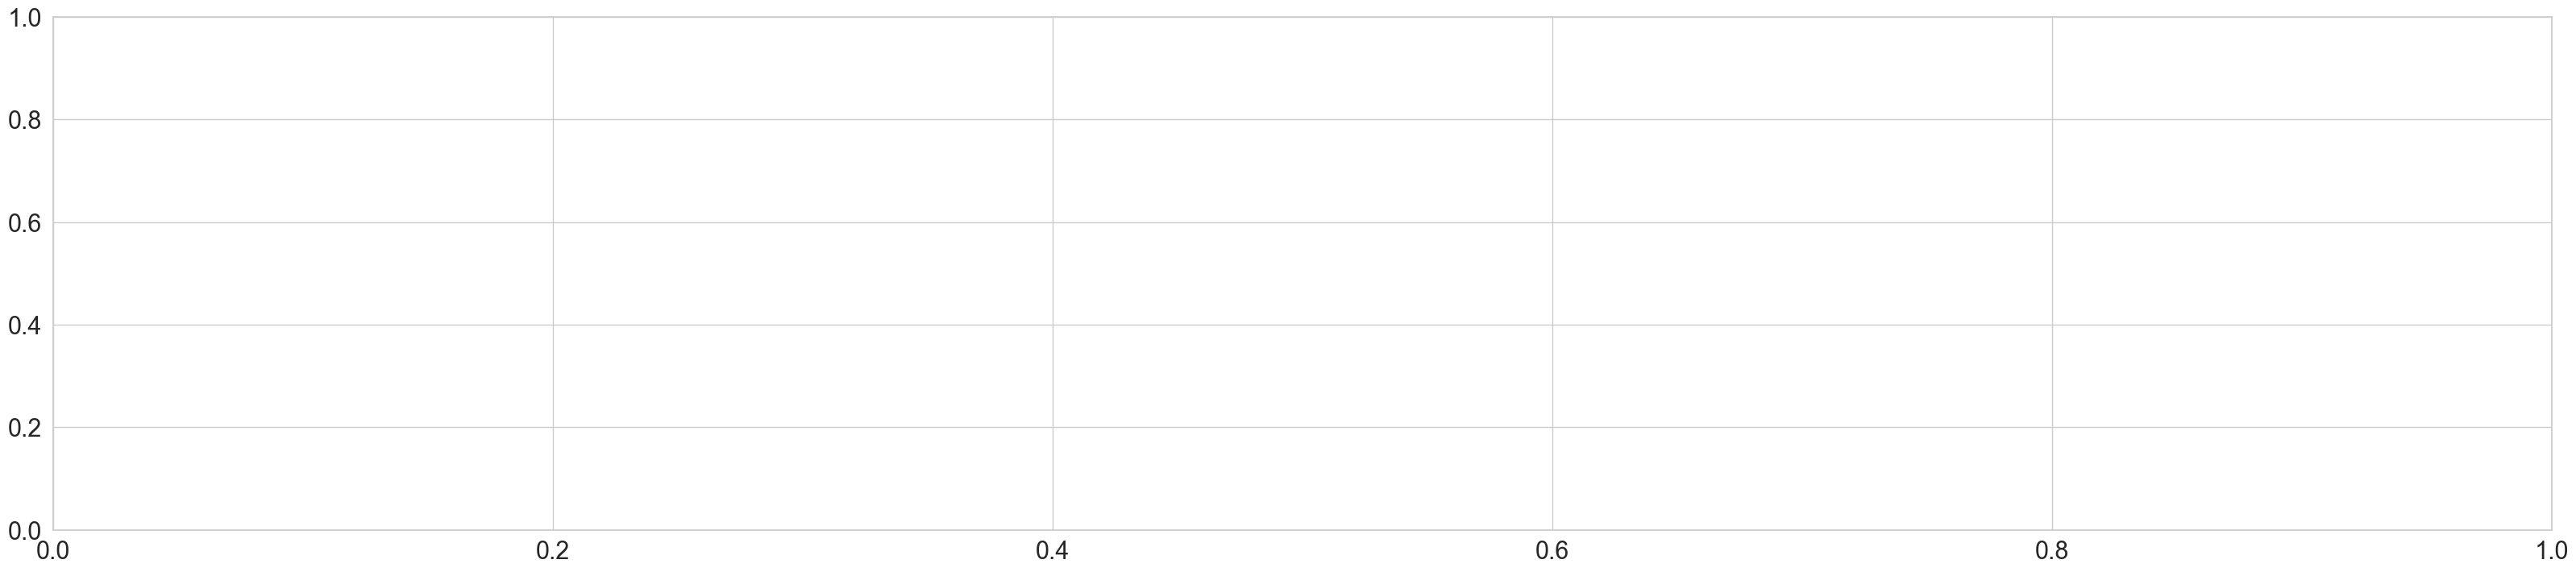

In [24]:
sns.set(rc={'figure.figsize':(40,8.27)},font_scale=2)
sns.set_style("whitegrid")

fig, ax = plt.subplots()

x = [i for i in range(1,43)]
y = df_bpm_bach_measure["BPM"].values

plt.scatter(x,y, s = 200, color="lightgray")

plt.xlabel("Measure")
plt.ylabel("Tempo (BPM)")

plt.title("Tempo Alterations per Part - Bach "+str(type_dict[name]) +"  (Pianist " + name[1] + ")")

plt.savefig("./plots/tempo/Tempo Alterations per Part - Bach "+str(type_dict[name]) +"  (Pianist " + name[1] + ").png")

In [25]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')
bach_parts_color = {
    (1,6): cmap(0), # first argument of tuple is measure, second is note
    (7,12): cmap(0.25),
    (13,16): cmap(0.5),
    (17,20): cmap(0.75)
    
}

NameError: name 'df_bpm_bach_measure' is not defined

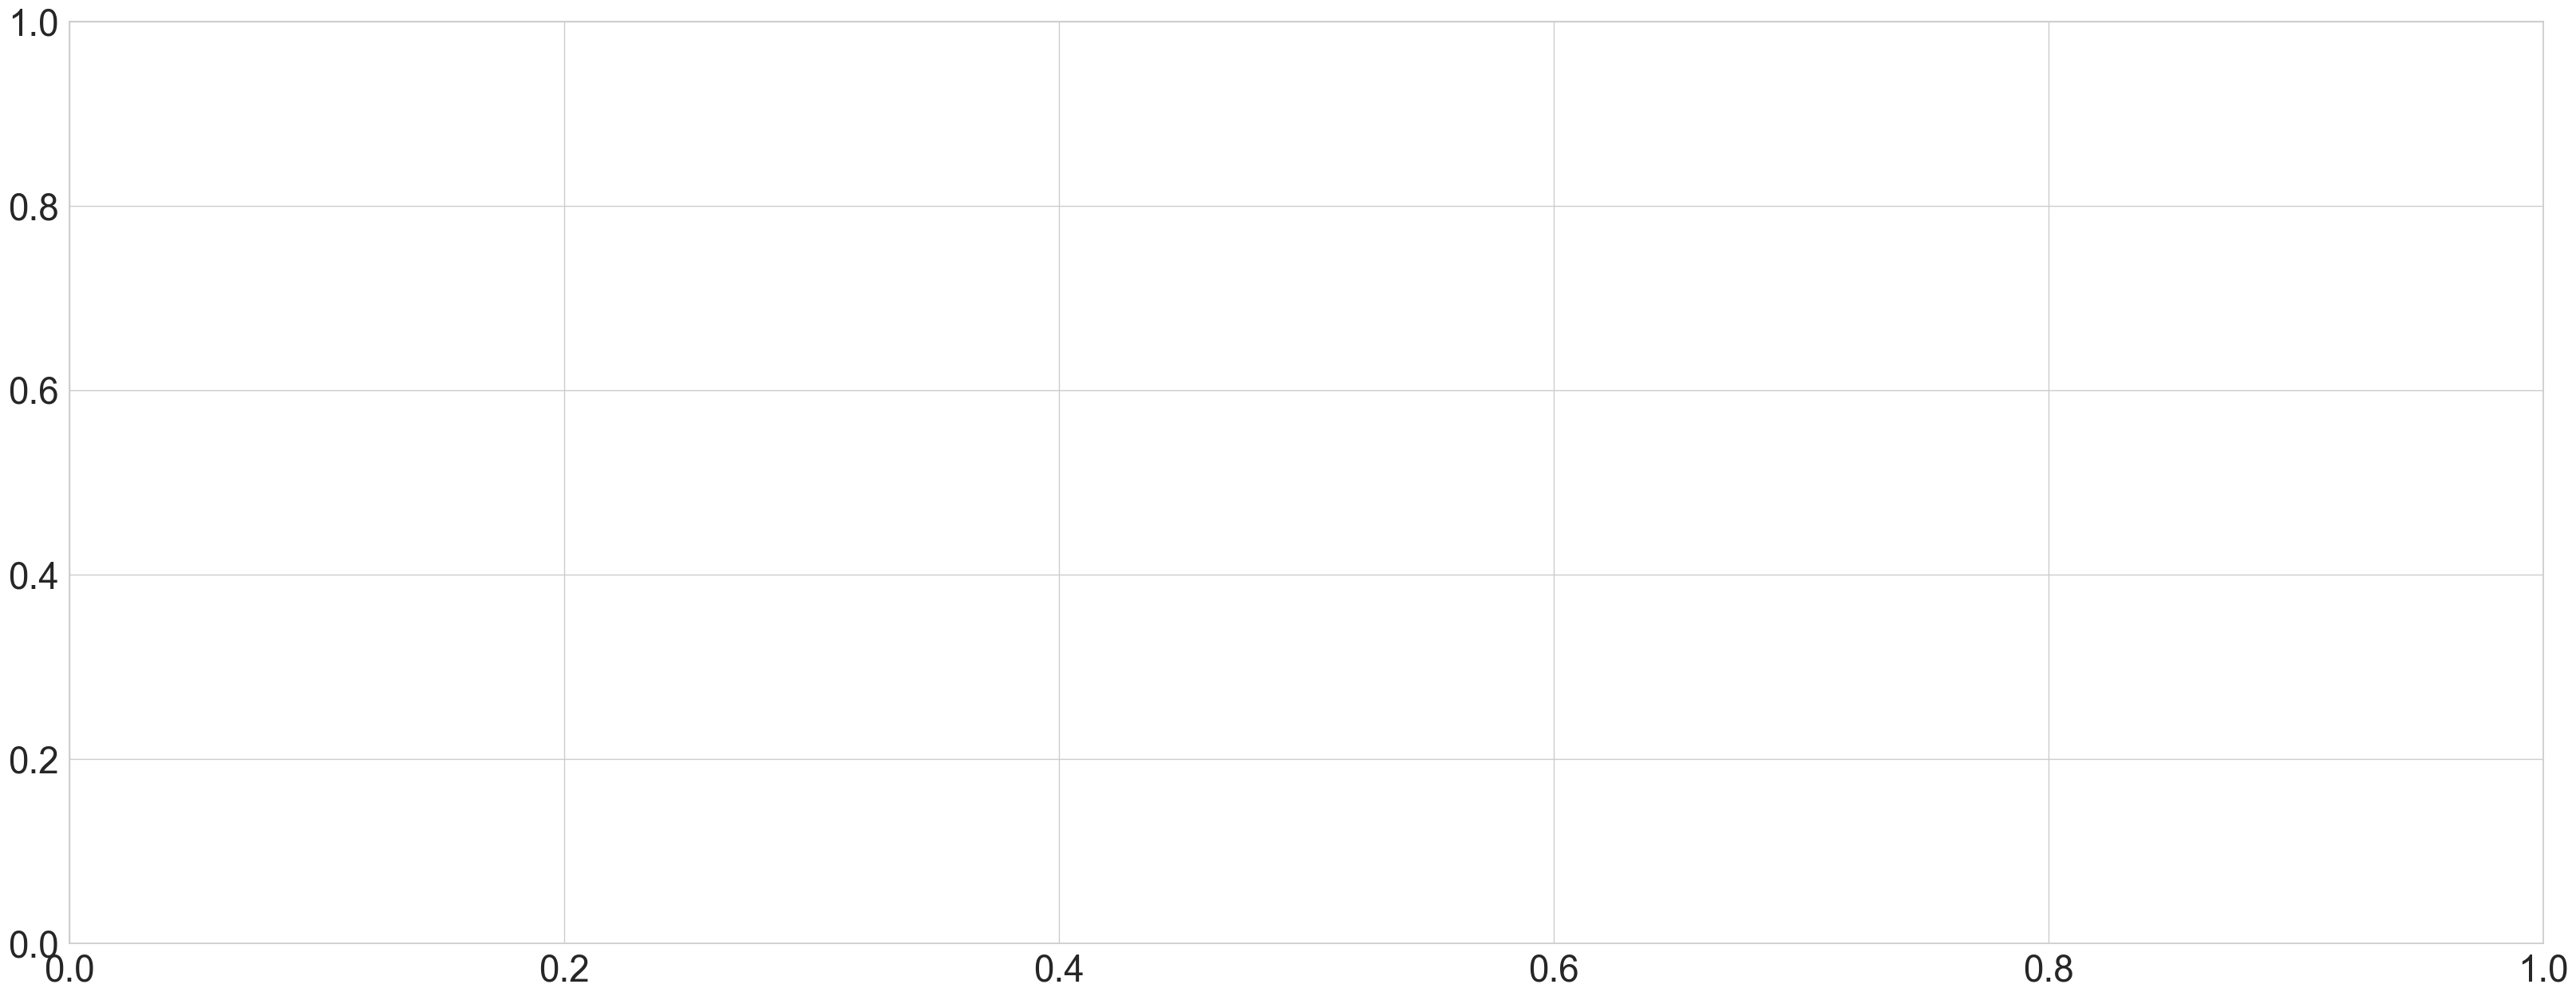

In [30]:
import matplotlib.font_manager as mfm
font_path = '/opt/anaconda3/envs/old_python/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf'
prop = mfm.FontProperties(fname=font_path)

sns.set(rc={'figure.figsize':(40,15)},font_scale=3)
sns.set_style("whitegrid")

fig, ax = plt.subplots()

avg_bpm = df_bpm_bach_measure["BPM"].describe()["mean"]

# print(3*len(df_bpm_bach_measure["Measure"].unique())/avg_bpm)
# print(3/avg_bpm)
# print(3/df_bpm_bach_measure["BPM"][0])

#length= 40/((12*3/avg_bpm)*len(df_bpm_bach_measure["Measure"].unique()))
length= 40/((12*3/avg_bpm)*20)
gap = (40 - length)/(len(df_bpm_bach_measure["Measure"].unique())-1)

print(length)
print(gap)

x_start = 0 
x_start_2 = 0

counter = 1

for i in range(1,21):
    
    color = None
    for key, value in bach_parts_color.items():
        start = key[0]
        end = key[1]
        if i in range(start,end+1):
            color = value
            break

    y = [0.05,0.05]
    x = [x_start, x_start+length]
    if(x_start == 0):
        plt.text(x_start, y=y[0]+0.01, s="Average tempo $♩$ = "+str(int(round(avg_bpm,0))),fontproperties=prop, fontsize = 35)
    
    if i==start:
        plt.plot(x,y, linewidth = 12, color = color, solid_capstyle = 'butt', label="Part "+str(counter)+" ("+str(start)+"-"+str(end)+")")
        counter +=1
    plt.plot(x,y, linewidth = 12, color = color, solid_capstyle = 'butt')
    y = [-0.15,-0.15]
    #length2 = 40/((12*3/avg_bpm)*len(df_bpm_bach_measure["Measure"].unique()))*(avg_bpm/df_bpm_bach_measure["BPM"][i-1])
    length2 = 40/((12*3/avg_bpm)*20)*(avg_bpm/df_bpm_bach_measure["BPM"][i-1])
    x = [x_start_2, x_start_2+length2]
    plt.plot(x,y, linewidth = 20, color = color, solid_capstyle = 'butt')
    plt.text(x_start_2, y=y[0]-0.05, s=str(int(round(df_bpm_bach_measure["BPM"].values[i],0))),fontproperties=prop, fontsize = 30)
    plt.plot([x_start,x_start_2], [0.05,-0.15], color = color, solid_capstyle = 'butt')
    
    x_start += length+gap 
    x_start_2 += length2+gap
    

plt.grid(False)
plt.ylim(-0.3,0.3)
#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis 
ax.get_yaxis().set_visible(False)

ax.legend(loc="upper right", bbox_to_anchor = (1,1),
          prop = mfm.FontProperties(family='Times',
                                   weight='bold',
                                   style='normal', size=40))
# legend_without_duplicate_labels(ax, (1, 1))

titlefont = {'fontname':'Times'}
plt.title("Average vs Local Tempi per Measure and Part, Prelude (Parts 1-4), "+str(type_dict[name]) +" (Pianist " + name[1] + ")", **titlefont, fontsize = 50)
plt.xlabel("")
plt.savefig("./plots/tempo/Tempo Alterations per Measure and Part, Prelude (Parts 1-4) "+str(type_dict[name]) +"  (Pianist " + name[1] + ").png")

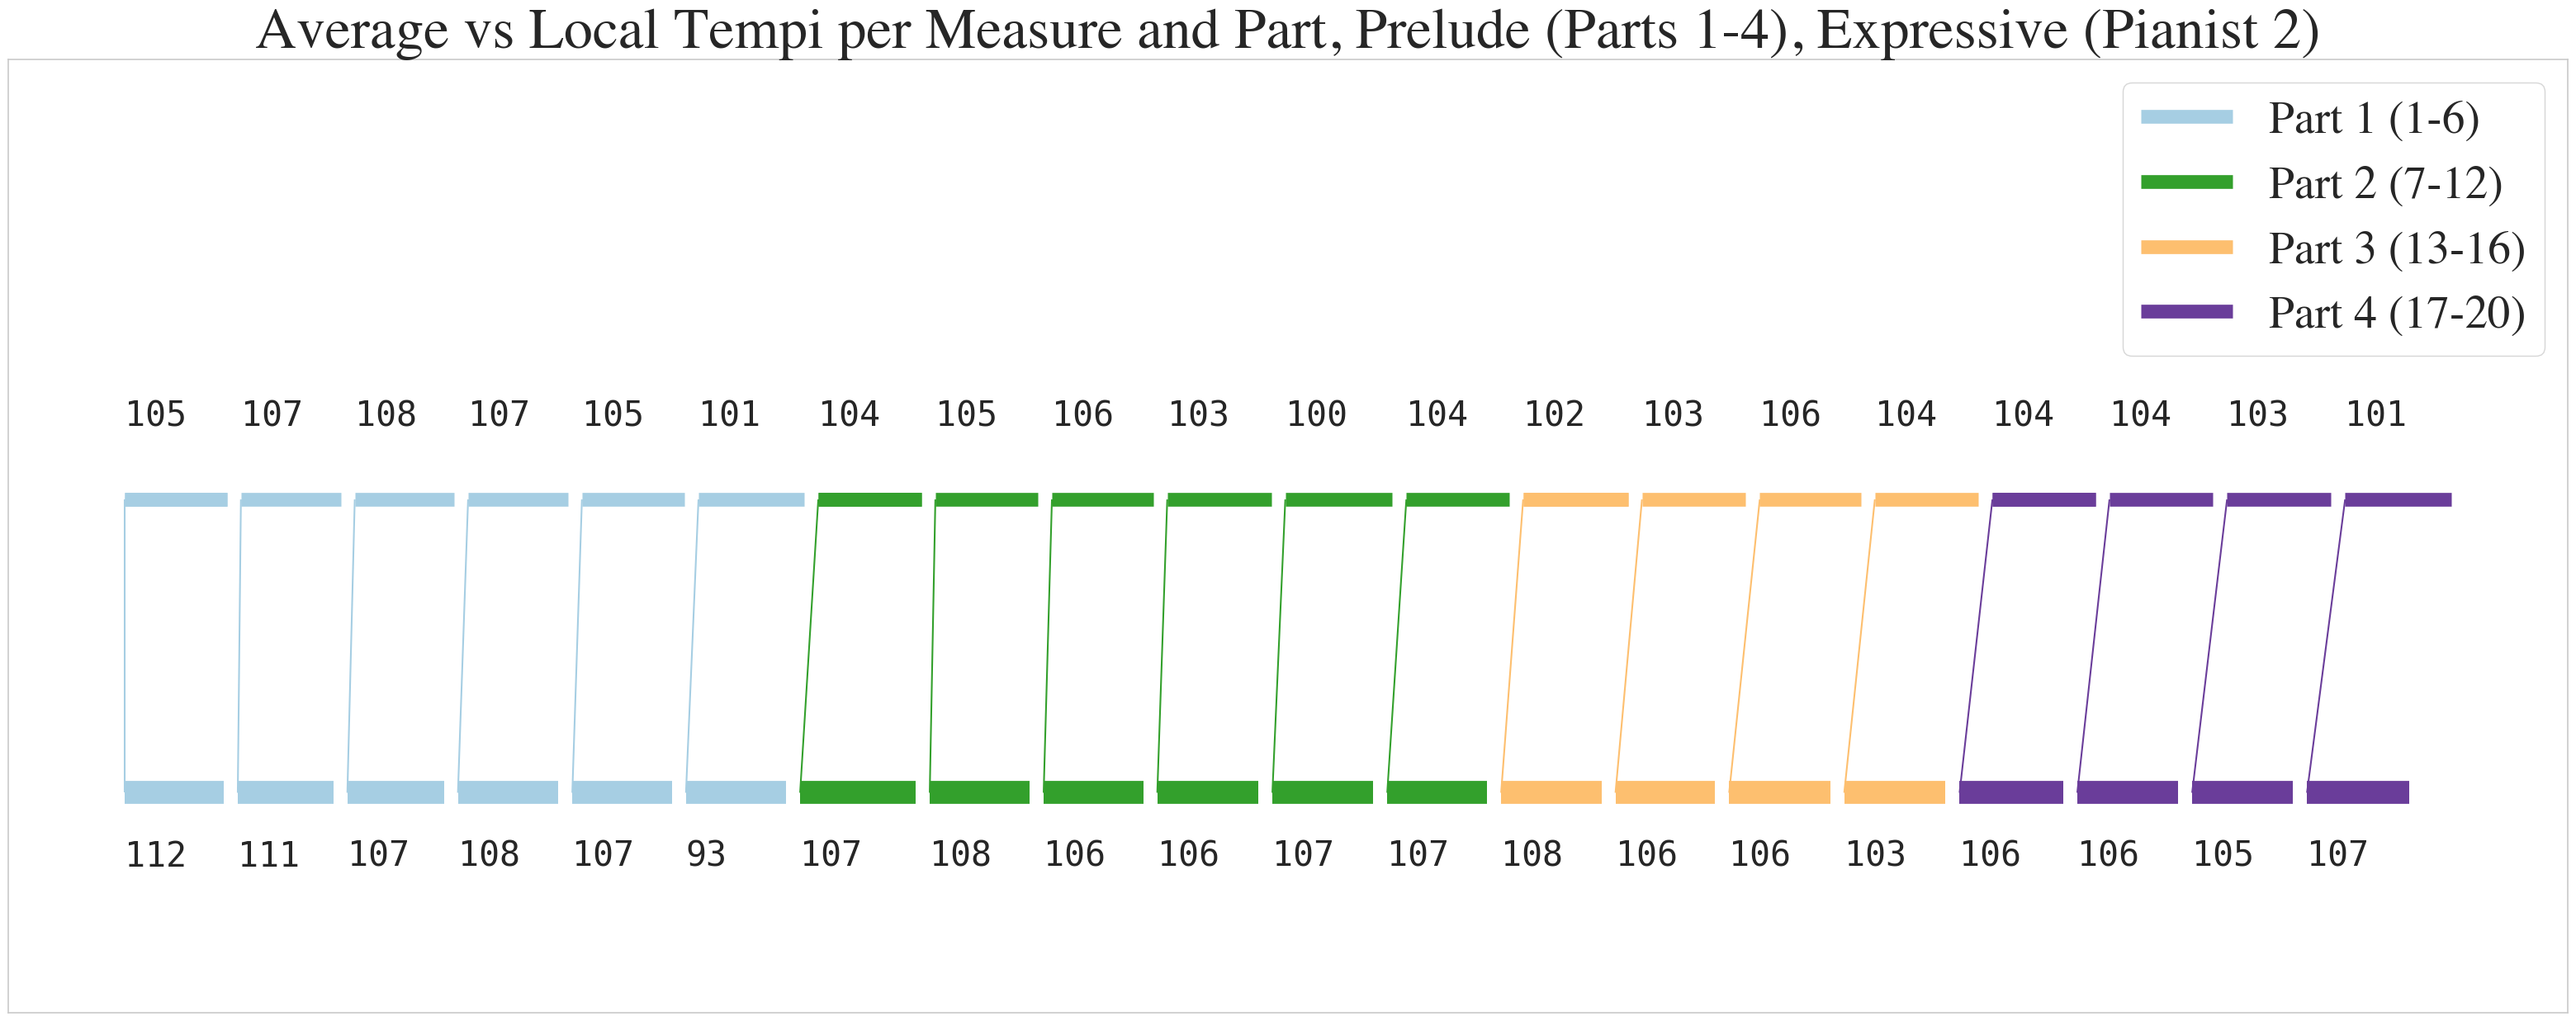

In [27]:
import matplotlib.font_manager as mfm
font_path = '/opt/anaconda3/envs/old_python/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf'
prop = mfm.FontProperties(fname=font_path)

sns.set(rc={'figure.figsize':(40,15)},font_scale=3)
sns.set_style("whitegrid")

fig, ax = plt.subplots()

avg_bpm = 107

# print(3*len(df_bpm_bach_measure["Measure"].unique())/avg_bpm)
# print(3/avg_bpm)
# print(3/df_bpm_bach_measure["BPM"][0])

#length= 40/((12*3/avg_bpm)*len(df_bpm_bach_measure["Measure"].unique()))
length= 40/((12*3/avg_bpm)*20)
gap = (40 - length)/(len(df_bpm_bach_measure_exp["Measure"].unique())-1)




x_start = 0 
x_start_2 = 0

counter = 1

for i in range(1,21):
    
    color = None
    for key, value in bach_parts_color.items():
        start = key[0]
        end = key[1]
        if i in range(start,end+1):
            color = value
            break
            
    length = 40/((12*3/avg_bpm)*20)*(avg_bpm/df_bpm_bach_measure_inexp["BPM"][i-1])

    y = [0.05,0.05]
    x = [x_start, x_start+length]

    plt.text(x_start, y=y[0]+0.05, 
             s=str(int(round(df_bpm_bach_measure_inexp["BPM"].values[i-1],0))),
             fontproperties=prop, 
             fontsize = 30)
    if i==start:
        plt.plot(x,y, linewidth = 12, color = color, solid_capstyle = 'butt', label="Part "+str(counter)+" ("+str(start)+"-"+str(end)+")")
        counter +=1
    plt.plot(x,y, linewidth = 12, color = color, solid_capstyle = 'butt')
    
    
    
    y = [-0.15,-0.15]
    length2 = 40/((12*3/avg_bpm)*20)*(avg_bpm/df_bpm_bach_measure_exp["BPM"][i-1])
    x = [x_start_2, x_start_2+length2]
    plt.plot(x,y, linewidth = 20, color = color, solid_capstyle = 'butt')
    plt.text(x_start_2, y=y[0]-0.05, s=str(int(round(df_bpm_bach_measure_exp["BPM"].values[i],0))),fontproperties=prop, fontsize = 30)
    plt.plot([x_start,x_start_2], [0.05,-0.15], color = color, solid_capstyle = 'butt')
    
    x_start += length+gap 
    x_start_2 += length2+gap
    

plt.grid(False)
plt.ylim(-0.3,0.35)
#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis 
ax.get_yaxis().set_visible(False)

ax.legend(loc="upper right", bbox_to_anchor = (1,1),
          prop = mfm.FontProperties(family='Times',
                                   weight='bold',
                                   style='normal', size=40))
# legend_without_duplicate_labels(ax, (1, 1))

titlefont = {'fontname':'Times'}
plt.title("Average vs Local Tempi per Measure and Part, Prelude (Parts 1-4), "+str(type_dict[name]) +" (Pianist " + name[1] + ")", **titlefont, fontsize = 50)
plt.xlabel("")
plt.savefig("./plots/tempo/Tempo Alterations Exp v Inexp per Measure and Part, Prelude (Parts 1-4) "+str(type_dict[name]) +"  (Pianist " + name[1] + ").png")

In [28]:
df_bpm_bach_measure_inexp

,Name,Measure,Note count,BPM
0,02_Bach_BWV999_inexp.csv,1,12,104.854369
1,02_Bach_BWV999_inexp.csv,2,12,107.462687
2,02_Bach_BWV999_inexp.csv,3,12,108.000000
3,02_Bach_BWV999_inexp.csv,4,12,107.462687
4,02_Bach_BWV999_inexp.csv,5,12,104.600484
5,02_Bach_BWV999_inexp.csv,6,12,101.408451
6,02_Bach_BWV999_inexp.csv,7,12,104.096386
7,02_Bach_BWV999_inexp.csv,8,12,104.600484
8,02_Bach_BWV999_inexp.csv,9,12,105.882353
9,02_Bach_BWV999_inexp.csv,10,12,103.102625


In [29]:
df_bpm_bach_measure_exp

,Name,Measure,Note count,BPM
0,02_Bach_BWV999_exp.csv,1,12,108.173077
1,02_Bach_BWV999_exp.csv,2,12,112.219451
2,02_Bach_BWV999_exp.csv,3,12,111.111111
3,02_Bach_BWV999_exp.csv,4,12,106.888361
4,02_Bach_BWV999_exp.csv,5,12,107.655502
5,02_Bach_BWV999_exp.csv,6,12,107.142857
6,02_Bach_BWV999_exp.csv,7,12,92.783505
7,02_Bach_BWV999_exp.csv,8,12,107.398568
8,02_Bach_BWV999_exp.csv,9,12,107.655502
9,02_Bach_BWV999_exp.csv,10,12,106.132075
